# fit to fake data

In [1]:
import sys
from pathlib import Path

import numpy as np
from astropy import table, nddata
from astropy.io import fits
from scipy import optimize
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import gridspec, colors, ticker
import cmocean
import betterplotlib as bpl

bpl.set_style()

# need to add the correct path to import utils
legus_home_dir = Path(".").resolve().parent
sys.path.append(str(legus_home_dir / "pipeline"))
import utils
import fit_utils

In [2]:
oversampling_factor = 2
psf_size = 15
snapshot_size = 30
snapshot_size_oversampled = snapshot_size * oversampling_factor

In [3]:
data_dir = legus_home_dir / "data" / "ngc1313-w"

psf_name = f"psf_my_stars_{psf_size}_pixels_{oversampling_factor}x_oversampled.fits"
psf = fits.open(data_dir / "size" / psf_name)["PRIMARY"].data

In [4]:
fake_params = [5, #lum
        30, # x
        30, # y 
        1, # a
        0.75, # q
        1.25, # theta
        1.75, #eta
        123] # bg

In [5]:
fake_data = fit_utils.create_model_image(
        *fake_params,
        psf,
        snapshot_size_oversampled,
        oversampling_factor,
    )[-1]

In [6]:
def calculate_chi_squared(params, cluster_snapshot, error_snapshot, mask):
    """
    Calculate the chi-squared value for a given set of parameters.

    :param params: Tuple of parameters of the EFF profile
    :param cluster_snapshot: Cluster snapshot
    :param error_snapshot: Error snapshot
    :param mask: 2D array used as the mask, that contains 1 where there are pixels to
                 use, and zero where the pixels are not to be used.
    :return:
    """
    _, _, model_snapshot = fit_utils.create_model_image(
        *params, psf, snapshot_size_oversampled, oversampling_factor
    )
    assert model_snapshot.shape == cluster_snapshot.shape
    assert model_snapshot.shape == error_snapshot.shape

    diffs = cluster_snapshot - model_snapshot
    sigma_snapshot = diffs / error_snapshot
    # then use the mask and the weights
    sigma_snapshot *= mask
    # do the radial weighting. Need to get the data coordinates of the center
    sigma_snapshot *= fit_utils.radial_weighting(
        cluster_snapshot,
        fit_utils.oversampled_to_image(params[1], oversampling_factor),
        fit_utils.oversampled_to_image(params[2], oversampling_factor),
        style="annulus",
    )
    return np.sum(np.abs(sigma_snapshot))

def postprocess_params(log_mu_0, x_c, y_c, a, q, theta, eta, background):
    """
    Postprocess the parameters, namely the axis ratio and position angle.

    This is needed since we let the fit have axis ratios larger than 1, and position
    angles of any value. Axis ratios larger than 1 indicate that we need to flip the
    major and minor axes. This requires rotating the position angle 90 degrees, and
    shifting the value assigned to the major axis to correct for the improper axis
    ratio.
    """

    # q and a can be negative, fix that before any further processing
    a = abs(a)
    q = abs(q)
    if q > 1.0:
        q_final = 1.0 / q
        a_final = a * q
        theta_final = (theta - (np.pi / 2.0)) % np.pi
        return log_mu_0, x_c, y_c, a_final, q_final, theta_final, eta, background
    else:
        return log_mu_0, x_c, y_c, a, q, theta % np.pi, eta, background


def negative_log_likelihood(
    params, cluster_snapshot, error_snapshot, mask
):
    """
    Calculate the negative log likelihood for a model

    We do the negative likelihood becuase scipy likes minimize rather than maximize,
    so minimizing the negative likelihood is maximizing the likelihood

    :param params: Tuple of parameters of the EFF profile
    :param cluster_snapshot: Cluster snapshot
    :param error_snapshot: Error snapshot
    :param mask: 2D array used as the mask, that contains 1 where there are pixels to
                 use, and zero where the pixels are not to be used.
    :param estimated_bg: the estimated background value, to be used as the mean of the
                         Gaussian prior on the background.
    :param estimated_bg_sigma: the scatter in the estimated background. The sigma of the
                               Gaussian prior on the background will be 0.1 times this.
    :return:
    """
    # postprocess them from the beginning to make things simpler. This allows the
    # fitting machinery to do what it wants, but under the hood we only use
    # reasonable parameter value. This also handles the background scaling.
    params = postprocess_params(*params)

    chi_sq = calculate_chi_squared(params, cluster_snapshot, error_snapshot, mask)
    log_data_likelihood = -chi_sq / 2.0
    # Need to postprocess the parameters before calculating the prior, as the prior
    # is on the physically reasonable values, we need to make sure that's correct.
    log_prior = 0
    log_likelihood = log_data_likelihood + log_prior
    assert not np.isnan(log_prior)
    assert not np.isnan(log_data_likelihood)
    assert not np.isinf(log_prior)
    assert not np.isinf(log_data_likelihood)
    assert not np.isneginf(log_prior)
    assert not np.isneginf(log_data_likelihood)
    # return the negative of this so we can minimize this value
    return -log_likelihood


def format_exponent(log_a, pos):
    assert np.isclose(float(log_a), int(log_a))
    log_a = int(log_a)

    if log_a > -2:
        return str(10 ** log_a)
    else:
        return "$10^{" + f"{log_a}" + "}$"


likelihood_cmap = cmocean.cm.haline

In [35]:
# ======================================================================================
# Keep everything the same at each point
# ======================================================================================
show_params = (5.026297634858521, 29.997908502276513, 30.00011168690735, 0.8236938032659896, 0.7079482413568882, 1.2471390258258346, 1.57103698691504, 122.60402042623873)

center_eta = show_params[6] #fake_params[6]
center_a = show_params[3] # fake_params[3]
d_eta = 0.0005
d_a = 0.0005
n_each = 20

eta_values = np.arange(center_eta - n_each * d_eta, center_eta + n_each * d_eta, d_eta)
a_values = np.arange(center_a - n_each * d_a, center_a + n_each * d_a, d_a)

n_eta = len(eta_values)
n_a = len(a_values)

# then make the output arrays
log_likelihood = np.zeros((n_a, n_eta))

for idx_eta in tqdm(range(n_eta)):
    for idx_a in range(n_a):
        eta = eta_values[idx_eta]
        a = a_values[idx_a]
        
        these_params = list(show_params).copy()
        these_params[3] = a
        these_params[6] = eta

        # Then plug these into the likelihood function to see what we get
        this_log_likelihood = -1 * negative_log_likelihood(
            these_params,
            fake_data,
            np.ones(fake_data.shape),
            np.ones(fake_data.shape),
        )


        log_likelihood[idx_a, idx_eta] = this_log_likelihood

100%|██████████| 41/41 [00:03<00:00, 12.65it/s]


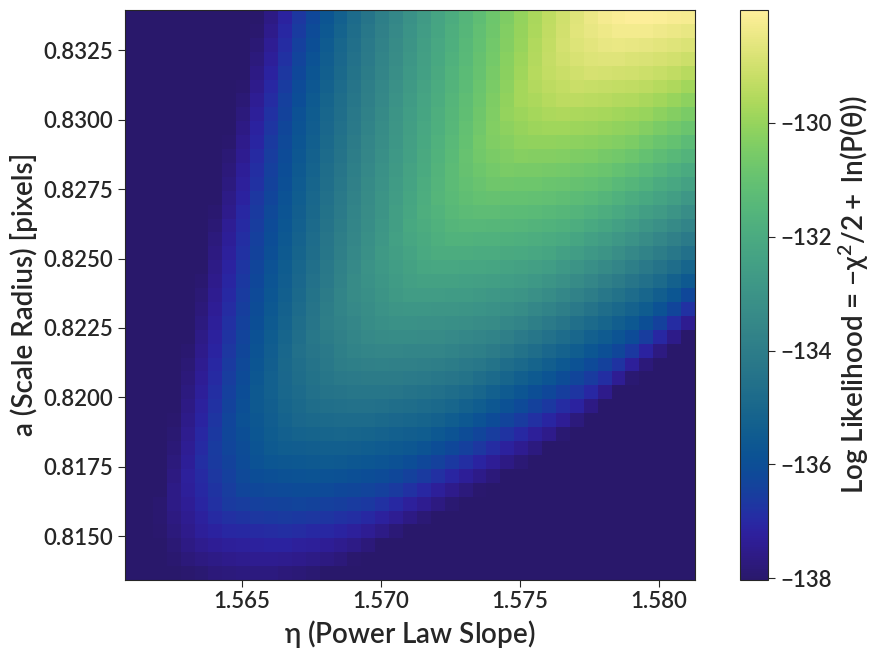

In [36]:
# ======================================================================================
# plot this
# ======================================================================================

fig, ax = bpl.subplots()

likelihood_width = 10

vmax = np.max(log_likelihood)
likelihood_norm = colors.Normalize(vmin=vmax - likelihood_width, vmax=vmax, clip=True)

limits = (
    min(eta_values) - 0.5 * d_eta,
    max(eta_values) + 0.5 * d_eta,
    min(a_values) - 0.5 * d_a,
    max(a_values) + 0.5 * d_a,
)
i = ax.imshow(
    log_likelihood,
    origin="lower",
    extent=limits,
    norm=likelihood_norm,
    cmap=likelihood_cmap,
    # This scalar aspect ratio is calculated to ensure the pixels are square
    aspect=((eta_max - eta_min) / n_eta) / ((a_max - a_min) / n_a),
)
cbar = fig.colorbar(i, ax=ax)
cbar.set_label("Log Likelihood = $-\chi^2/2 +$ ln$(P(\\theta))$")

ax.set_limits(*limits)

# mark the best fit point
ax.scatter(
    [fake_params[-2]],
    [fake_params[3]],
    marker="x",
    c=bpl.almost_black,)




ax.add_labels("$\eta$ (Power Law Slope)", "a (Scale Radius) [pixels]")
# ax.easy_add_text(f"{galaxy.upper()} - {cluster_id}", "upper left", color="white")
# fig.savefig(
# Path(__file__).parent / f"likelihood_contours_priors_{galaxy}_{cluster_id}.png",
# bbox_inches="tight",
# )